# Camera studies

In [1]:
# 1. Run on prompt
# daniel@simbox /opt/carla-simulator $ ./CarlaUE4.sh 

# 2. boilerplate code
import carla 
import math 
import random 
import time 
import carla_helpers as helpers

# Connect to the client and get the world object
client = carla.Client('localhost', 2000) 
world = client.get_world() 

# load Town04 map
world = client.load_world('Town04')

## Helper functions

In [3]:
def get_figure8_waypoints(world):
    # Town04 figure-8 track waypoints to be more precise
    # road_sequence = [42, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]
    # road_sequence = [35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]
    road_sequence = [42, 267, 43, 35, 861, 36, 760, 37, 1602, 38, 1091, 39, 1184, 40, 1401, \
                                                                       41, 6, 45, 145, 46, 1072, 47, 774, 48, 901, 49, 1173, 50]
    carla_map = world.get_map()
    waypoints = carla_map.generate_waypoints(1.0)
    
    all_waypoints = []
    for road_id in road_sequence:
        road_waypoints = [wp for wp in waypoints if wp.road_id == road_id and wp.lane_id == -3]
        road_waypoints.sort(key=lambda x: x.s)
        all_waypoints.extend(road_waypoints)
        
    return all_waypoints

def set_spectator_camera_following_car(world, vehicle):
    """
    Position the spectator 3 meters above and 5 meters behind the vehicle.
    
    Parameters:
    - world: CARLA world object.
    - vehicle: CARLA vehicle object.
    
    Returns:
    - spectator: CARLA spectator object.
    """
    spectator = world.get_spectator()
    vehicle_transform = vehicle.get_transform()

    # Get the vehicle's forward vector (direction it's facing)
    forward_vector = vehicle_transform.get_forward_vector()

    # Calculate the offset position: 5 meters behind and 3 meters above the vehicle
    offset_location = vehicle_transform.location + carla.Location(
        x=-5 * forward_vector.x,  # 5 meters behind along the forward axis
        y=-5 * forward_vector.y,  # 5 meters behind along the forward axis
        z=3  # 3 meters above
    )

    # Set the spectator transform with a fixed pitch for a better view
    spectator.set_transform(carla.Transform(
        offset_location,
        carla.Rotation(pitch=-15, yaw=vehicle_transform.rotation.yaw, roll=0)  # Slightly tilted down
    ))
    return spectator

def compute_control(vehicle, target_wp, target_speed=10):  # Reduced target speed to 10 km/h
    """
    Compute vehicle control to reach the target waypoint at a specified speed.
    
    Parameters:
    - vehicle: CARLA vehicle object.
    - target_wp: Target waypoint.
    - target_speed: Desired speed in km/h (default is 10 km/h).
    
    Returns:
    - control: CARLA VehicleControl object.
    """
    control = carla.VehicleControl()

    # Get current state
    current_transform = vehicle.get_transform()
    current_velocity = vehicle.get_velocity()
    speed = 3.6 * math.sqrt(current_velocity.x**2 + current_velocity.y**2)  # Convert to km/h

    # Steering control
    forward = current_transform.get_forward_vector()
    target_vector = target_wp.transform.location - current_transform.location
    forward_dot = forward.x * target_vector.x + forward.y * target_vector.y
    right_dot = -forward.y * target_vector.x + forward.x * target_vector.y
    steering = math.atan2(right_dot, forward_dot) / math.pi
    control.steer = max(-1.0, min(1.0, steering))  # Clamp steering to [-1, 1]

    # Speed control
    speed_error = target_speed - speed
    if speed_error > 0:
        # If below target speed, apply throttle
        control.throttle = min(0.3, speed_error / target_speed)  # Reduced throttle limit to 0.3
        control.brake = 0.0
    else:
        # If above target speed, apply brake
        control.throttle = 0.0
        control.brake = min(0.3, -speed_error / target_speed)  # Reduced brake limit to 0.3

    return control

def drive_figure_eight(world, vehicle, waypoints, target_speed=10):
    """
    Drive the vehicle along the figure-8 track at a specified speed.
    
    Parameters:
    - world: CARLA world object.
    - vehicle: CARLA vehicle object.
    - waypoints: List of waypoints for the figure-8 track.
    - target_speed: Desired speed in km/h (default is 10 km/h).
    """
    try:
        for i, wp in enumerate(waypoints):
            print(f"Current target waypoint {i + 1}/{len(waypoints)}: {wp.transform.location}")
            
            # Draw the current target waypoint
            world.debug.draw_point(
                wp.transform.location,
                size=0.2,  # Size of the marker
                color=carla.Color(255, 0, 0),  # Red color
                life_time=5.0  # Persist for 5 seconds
            )
            
            # Drive toward the current waypoint
            while True:
                control = compute_control(vehicle, wp, target_speed)
                vehicle.apply_control(control)
                
                # Update spectator camera
                set_spectator_camera_following_car(world, vehicle)
                
                # Check if the vehicle is close to the current waypoint
                current_location = vehicle.get_transform().location
                distance_to_waypoint = current_location.distance(wp.transform.location)
                if distance_to_waypoint < 2.0:  # Proceed to the next waypoint if within 2 meters
                    break
                
                if world.get_settings().synchronous_mode:
                    world.tick()
                else:
                    time.sleep(0.1)  # Increased delay to 0.1 seconds
                    
    except KeyboardInterrupt:
        print("Simulation interrupted by user.")
        control = carla.VehicleControl(throttle=0, brake=1)
        vehicle.apply_control(control)

def draw_permanent_waypoint_lines(world, waypoints, color=carla.Color(0, 255, 0), thickness=0.02):
    """
    Draw permanent lines linking every waypoint on the road.
    
    Parameters:
    - world: CARLA world object.
    - waypoints: List of waypoints to link.
    - color: Color of the lines (default is neon green).
    - thickness: Thickness of the lines (default is 0.1 meters).
    """
    for i in range(len(waypoints) - 1):
        # Get the current and next waypoint
        wp1 = waypoints[i]
        wp2 = waypoints[i + 1]
        
        # Draw a line between the two waypoints
        world.debug.draw_line(
            wp1.transform.location,  # Start point
            wp2.transform.location,  # End point
            thickness=thickness,     # Line thickness
            color=color,             # Line color
            life_time=0             # Permanent line (life_time=0 means infinite)
        )        

## Camera functions

Number of waypoints retrieved: 3063
Vehicle spawned at Location(x=160.342804, y=-368.140472, z=2.000000)
Camera attached to vehicle at Location(x=1.000000, y=0.000000, z=1.500000)
Image size verified successfully.
Camera position: Location(x=161.342758, y=-368.131714, z=2.250500)
Camera rotation: Rotation(pitch=4.999999, yaw=0.501399, roll=0.000000)


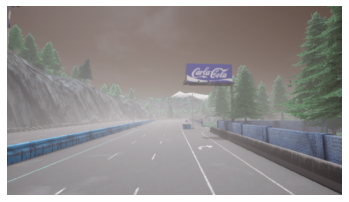

Camera destroyed.
Vehicle destroyed.


In [3]:
import carla
import numpy as np
import queue
import time
import matplotlib.pyplot as plt

# Constants
CAMERA_WIDTH = 640  # Image width in pixels
CAMERA_HEIGHT = 360  # Image height in pixels
CAMERA_FOV = 90  # Field of view in degrees
CAMERA_POSITION = carla.Location(x=1, y=0.0, z=1.5)  # Position relative to the vehicle
CAMERA_ROTATION = carla.Rotation(pitch=5.0, yaw=0.0, roll=0.0)  # Rotation relative to the vehicle

def spawn_vehicle(world, waypoints):
    """
    Spawn a vehicle at the first waypoint.
    
    Parameters:
    - world: CARLA world object.
    - waypoints: List of waypoints for the figure-8 track.
    
    Returns:
    - vehicle: CARLA vehicle object.
    """
    # Get the blueprint for the vehicle
    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("vehicle.tesla.model3")[0]  # Choose a vehicle blueprint

    # Spawn the vehicle at the first waypoint
    spawn_point = waypoints[0].transform
    spawn_point.location.z += 2.0  # Adjust spawn height to avoid collisions
    vehicle = world.spawn_actor(vehicle_bp, spawn_point)
    print(f"Vehicle spawned at {spawn_point.location}")
    return vehicle

def attach_camera_to_vehicle(world, vehicle):
    """
    Attach a camera to the vehicle and set up the image capture.
    
    Parameters:
    - world: CARLA world object.
    - vehicle: CARLA vehicle object.
    
    Returns:
    - camera: CARLA camera object.
    - image_queue: Queue to store captured images.
    """
    # Get the blueprint for the camera
    blueprint_library = world.get_blueprint_library()
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", str(CAMERA_WIDTH))
    camera_bp.set_attribute("image_size_y", str(CAMERA_HEIGHT))
    camera_bp.set_attribute("fov", str(CAMERA_FOV))

    # Attach the camera to the vehicle
    camera_transform = carla.Transform(CAMERA_POSITION, CAMERA_ROTATION)
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
    print(f"Camera attached to vehicle at {camera_transform.location}")

    # Create a queue to store captured images
    image_queue = queue.Queue()

    # Set up the callback to store images in the queue
    camera.listen(image_queue.put)

    return camera, image_queue

def process_image(image):
    """
    Process the captured image and convert it to a numpy array.
    
    Parameters:
    - image: CARLA image object.
    
    Returns:
    - image_array: Numpy array representing the image.
    """
    # Convert the raw image data to a numpy array
    image_array = np.frombuffer(image.raw_data, dtype=np.uint8)
    image_array = image_array.reshape((CAMERA_HEIGHT, CAMERA_WIDTH, 4))  # RGBA format
    image_array = image_array[:, :, :3]  # Remove alpha channel (keep only RGB)
    return image_array

def plot_image(image_array):
    """
    Plot the captured image using matplotlib.
    
    Parameters:
    - image_array: Numpy array representing the image.
    """
    plt.imshow(image_array)
    plt.axis("off")  # Hide axes
    plt.show()

def test_vehicle_and_camera(world):
    """
    Unit test to verify vehicle and camera instantiation, image size, and camera positioning.
    """
    # Connect to the CARLA server
    # Declared at top of script
    # client = carla.Client("localhost", 2000)
    # client.set_timeout(10.0)
    # world = client.get_world()

    # Enable synchronous mode
    settings = world.get_settings()
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 0.05
    world.apply_settings(settings)

    try:
        # Get waypoints for the figure-8 track
        waypoints = get_figure8_waypoints(world)
        print(f"Number of waypoints retrieved: {len(waypoints)}")

        # Spawn the vehicle
        vehicle = spawn_vehicle(world, waypoints)

        # Attach the camera to the vehicle
        camera, image_queue = attach_camera_to_vehicle(world, vehicle)

        # Advance the simulation to allow the camera to capture an image
        for _ in range(10):  # Advance 10 frames
            world.tick()

        # Wait for the image to be captured
        start_time = time.time()
        while time.time() - start_time < 5.0:  # Wait up to 5 seconds
            if not image_queue.empty():
                image = image_queue.get()
                image_array = process_image(image)

                # Verify image size
                assert image_array.shape == (CAMERA_HEIGHT, CAMERA_WIDTH, 3), \
                    f"Image size mismatch: expected {(CAMERA_HEIGHT, CAMERA_WIDTH, 3)}, got {image_array.shape}"
                print("Image size verified successfully.")

                # Print camera position and rotation
                camera_transform = camera.get_transform()
                print(f"Camera position: {camera_transform.location}")
                print(f"Camera rotation: {camera_transform.rotation}")

                # Plot the captured image
                plot_image(image_array)
                break
            time.sleep(0.1)  # Small delay to avoid busy-waiting
        else:
            print("No image captured within the timeout period. Check camera setup.")
    finally:
        # Clean up
        if 'camera' in locals():
            camera.destroy()
            print("Camera destroyed.")
        if 'vehicle' in locals():
            vehicle.destroy()
            print("Vehicle destroyed.")

# world declared at top of script
test_vehicle_and_camera(world)

Number of waypoints retrieved: 3063
Vehicle spawned at Location(x=160.342804, y=-368.140472, z=2.000000)
Camera attached to vehicle at Location(x=1.000000, y=0.000000, z=1.800000)
Image size verified successfully.
Camera position: Location(x=161.342758, y=-368.131714, z=2.550500)
Camera rotation: Rotation(pitch=-14.999996, yaw=0.501399, roll=0.000000)


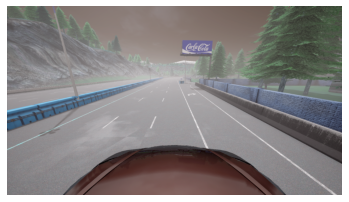

Camera destroyed.
Vehicle destroyed.


In [4]:
# Realistic camera parameters
CAMERA_WIDTH = 1920  # Full HD resolution
CAMERA_HEIGHT = 1080
CAMERA_FOV = 120  # Medium FOV
CAMERA_FPS = 30  # Frame rate
CAMERA_POSITION = carla.Location(x=1, y=0.0, z=1.8)  # Mounting position
CAMERA_ROTATION = carla.Rotation(pitch=-15.0, yaw=0.0, roll=0.0)  # Tilted downward
test_vehicle_and_camera(world)

# Vehicle camera position study vehicle.tesla.model3
vehicle_model = "sedan"  # Or whatever model your sim supports
waypoint = {"x": 10, "y": 20, "z": 0, "yaw": 90}
vehicle = spawn_vehicle(vehicle_model, waypoint)

In [5]:
import carla
import time

def list_vehicles_in_world(world):
    # Connect to the CARLA server
    #client = carla.Client('localhost', 2000)  # Default host and port
    #client.set_timeout(10.0)  # 10 seconds timeout for connection

    # Get the current world
    world = client.get_world()

    # Get all actors in the world
    actors = world.get_actors()

    # Filter for vehicles only
    vehicles = actors.filter('vehicle.*')

    # List the vehicles
    if len(vehicles) == 0:
        print("No vehicles found in the CARLA world.")
    else:
        print(f"Found {len(vehicles)} vehicles in the CARLA world:")
        for i, vehicle in enumerate(vehicles, 1):
            # Get vehicle type and ID
            vehicle_type = vehicle.type_id.replace('vehicle.', '')  # Remove 'vehicle.' prefix
            vehicle_id = vehicle.id
            # Get vehicle location
            location = vehicle.get_location()
            print(f"{i}. Type: {vehicle_type}, ID: {vehicle_id}, Location: (x={location.x:.2f}, y={location.y:.2f}, z={location.z:.2f})")

    return vehicles

def main(world):
    try:
        list_vehicles_in_world(world)
    except Exception as e:
        print(f"Error: {e}")
    finally:
        # Small delay to ensure output is visible before script ends
        time.sleep(1)

main(world)        

Found 1 vehicles in the CARLA world:
1. Type: tesla.model3, ID: 147, Location: (x=160.34, y=-368.14, z=0.75)


In [6]:
# vehicle = world.get_actor(147)
# spectator = world.get_spectator()

# # Get the vehicle's transform (location and rotation)
# vehicle_transform = vehicle.get_transform()

# # Set the spectator's transform to match the vehicle's location
# #spectator.set_transform(carla.Transform(vehicle_transform.location, vehicle_transform.rotation))
# spectator.set_transform(vehicle_transform)

waypoints = get_figure8_waypoints(world)
waypoints[0]

In [ ]:
from carla_helpers import *
spectator = world.get_spectator()
set_spectator_transform(world, waypoints[0].transform.location , spectator)